## 仓位管理-multi_signal_add_position

### 一、多信号加仓法

## 1.多信号加仓法

 满足信号的个数越多，加仓越多。
 
 见 onBar ‘多信号加仓模块’以及on15Bar‘信号计算与开仓逻辑’
 
用参数 n 控制加仓次数，参数fixsize为开仓手数以及每次加仓数量

### 开仓算法如下：

计算3个指标分别为MACD,RSI,movement并计算信号值signal_1,signal_2,signal_3和signal. signal = signal_1+signal_2+signal_3

if not 空头信号 and signal == 1:

    buy
    
elif not 多头信号 and signal == -1:

    short
    
### 加仓算法如下：

if 持多头仓位 and 当前加仓次数 nPos < 2：

    if 出现空头信号：
    
        sell 全部多头头寸
        
    elif 没加过仓 and signal == 2:
    
        加仓fixsize手
        
    elif 加过一次仓 and signal == 3:
    
        加仓fixsize手
    
elif 持空头仓位 and 当前加仓次数 nPos < 2：

    if 出现多头信号：
    
        cover 全部空头头寸
        
    elif 没加过仓 and signal == -2:
    
        加仓fixsize手
        
    elif 加过一次仓 and signal == -3:
    
        加仓fixsize手
        

### 当执行平仓信号，将 nPos 重置为 0 

if 持有多头仓位 and 死叉：

    nPos = 0
    
elif 持有空头仓位 and 金叉：

    nPos = 0

In [ ]:
#策略参数    
    barPeriod = 200
    fastWindow = 60     # 快速均线参数
    slowWindow = 120     # 慢速均线参数
    
# 变量列表
    nPos = 0
    fixsize = 10
    trailingPercent = 4

    stopRatio = 0.02       # 止损百分比
    profitMultiplier = 6   # 止盈与止损比例
    transactionPrice = {}  # 记录成交价格
    intraTradeHighDict = {}
    intraTradeLowDict = {}
    Ratio = 0.02
    signal_1 = 0
    signal_2 = 0
    signal_3 = 0
    signal = 0
    
# 设置变量    
        self.transactionPrice = {s: 0 for s in self.symbolList}
        self.intraTradeHighDict = {s: 0 for s in self.symbolList}
        self.intraTradeLowDict ={s: 0 for s in self.symbolList}
    
        
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        symbol = bar.vtSymbol
        
        if self.posDict[symbol+"_LONG"] == 0 and self.posDict[symbol+"_SHORT"] == 0:
            self.intraTradeHighDict[symbol] = 0
            self.intraTradeLowDict[symbol] = 999999
        # 洗价器        
        # 多信号加仓模块，多空相反______________________________________
        elif self.posDict[symbol+"_LONG"]!=0 :    # 持有多头仓位并且加仓次数不超过2次(共三个信号，允许加2次仓)
            self.intraTradeHighDict[symbol] = max(self.intraTradeHighDict[symbol], bar.high)
            self.intraTradeLowDict[symbol] = bar.low
            self.longStop = self.intraTradeHighDict[symbol]*(1-self.trailingPercent/100)
#             print('最高价:%s'%self.intraTradeHighDict[symbol])
#             print('止损价格:%s'%self.longStop)
#             print('开仓价格:%s'%self.transactionPrice)
            if bar.close<=self.longStop or (bar.close > self.transactionPrice[symbol] * (1 + self.profitMultiplier * self.stopRatio)):
                self.cancelAll()
                self.sell(symbol, bar.close*0.98, self.posDict[symbol+"_LONG"])
                self.signal_1 = 0
                self.signal_2 = 0
                self.signal_3 = 0
                self.signal = 0 
            elif self.signal_1 < 0 or self.signal_2 < 0 or self.signal_3 < 0:   # 持有多仓情况下有一个信号转换为空头信号，则清仓出场
                self.sell(symbol,bar.close*0.98, self.posDict[symbol+"_LONG"]) # 全部头寸出场
                print('time:%s,on bar sell:%s'%(bar.datetime,bar.close))
                self.signal_1 = 0
                self.signal_2 = 0
                self.signal_3 = 0
                self.signal = 0 
            elif self.nPos == 0 and self.signal == 2:   # 第一次开仓是有一个信号满足，当另一个信号满足多头信号，则加仓
                self.nPos += 1  # 加仓次数减少 1 次
                self.buy(symbol,bar.close*1.02,self.fixsize)  # 加仓数量固定fixsize
                print('time:%s,onbar_long_add:%s,n:%s'%(bar.datetime,bar.close,self.nPos))
            elif self.nPos == 1 and self.signal == 3 :   # 建立在第一次加仓的基础上，再有信号满足多头信号，继续加仓
                self.buy(symbol,bar.close*1.02,self.fixsize)  # 加仓数量固定fixsize
                print('time:%s,onbar_long_add2:%s,n:%s'%(bar.datetime,bar.close,self.nPos+1))
        elif self.posDict[symbol + "_SHORT"] != 0:
            self.intraTradeLowDict[symbol] = min(self.intraTradeLowDict[symbol], bar.low)
            self.intraTradeHighDict[symbol] = bar.high
            self.shortStop = self.intraTradeLowDict[symbol]*(1+self.trailingPercent/100)
            if (bar.close>=self.shortStop) or (bar.close < self.transactionPrice[symbol] * (1 - self.profitMultiplier * self.stopRatio)):
                self.cancelAll()
                self.cover(symbol, bar.close*1.02, self.posDict[symbol+"_SHORT"])  
                print('time:%s,shortStop cover:%s'%(bar.datetime,bar.high))
                self.signal_1 = 0
                self.signal_2 = 0
                self.signal_3 = 0
                self.signal = 0
            elif self.signal_1 > 0 or self.signal_2 > 0 or self.signal_3 > 0:   #
                self.cover(symbol,bar.close*1.02, self.posDict[symbol+"_SHORT"])
                self.signal_1 = 0
                self.signal_2 = 0
                self.signal_3 = 0
                self.signal = 0 
                print('time:%s,onbar cover:%s'%(bar.datetime,bar.close))
            elif self.nPos == 0 and self.signal == -2 :   # 计算盈利比例
                self.nPos += 1  # 加仓次数减少 1 次
                self.short(symbol,bar.close*0.98,self.fixsize)  # 加仓数量固定fixsize
                print('time:%s,onbar_short_add:%s,n:%s'%(bar.datetime,bar.close,self.nPos))
            elif self.nPos == 1 and self.signal == -3 :
                self.short(symbol,bar.close*0.98,self.fixsize)  # 加仓数量固定fixsize
                print('time:%s,onbar_short_add2:%s,n:%s'%(bar.datetime,bar.close,self.nPos+1))
        # 发出状态更新事件
        self.putEvent()
        
    def on15MinBar(self, bar):
        """30分钟K线推送"""
        symbol = bar.vtSymbol
    
        am15 = self.getArrayManager(symbol, "15m")

        if not am15.inited:
            return
        
        # 计算策略需要的信号，共三个信号分别是MACD,rsi,动量指标-------------------------------------------------
        diff,dea,hist = ta.MACD(am15.close)
        
        if diff[-1]<0 and dea[-1]<0 and diff[-2]<dea[-2] and diff[-1]>dea[-1]:  
            self.signal_1 = 1
        elif diff[-1]>0 and dea[-2]>0 and diff[-2]>dea[-2] and diff[-1]<dea[-1]:
            self.signal_1 = -1
        else:
            self.signal_1 = 0
        
        rsi = ta.RSI(am15.close)
        
        if rsi[-2]<38 and rsi[-1]>38:
            self.signal_2 = 1
        elif rsi[-2]>68 and rsi[-1]<68:
            self.signal_2 = -1
        else:
            self.signal_2 = 0    
        
        movement = (am15.close[-1] - am15.close[-10])/am15.close[-10]
        
        if movement < -0.015:
            self.signal_3 = 1
        elif movement > 0.015:
            self.signal_3 = -1
        else:
            self.signal_3 = 0
        ###    将三个信号加和
        self.signal = self.signal_1 + self.signal_2 + self.signal_3
        
        # 构建进出场逻辑-------------------------------------------------
        # 如果3个都不是空头信号，并且有一个信号满足多头信号，则开多仓
        if self.signal_1 >= 0 and self.signal_2 >= 0 and self.signal_3 >= 0 and self.signal == 1:
            # 如果金叉时手头没有持仓，则直接做多
            if (self.posDict[symbol+'_LONG']==0) and (self.posDict[symbol+'_SHORT']==0):
                self.buy(symbol, bar.close*1.02, self.fixsize*0.3)
                print('time:%s,nornal_buy:%s'%(bar.datetime,bar.close))
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] >0:
                #print('short_pos:%s'%self.posDict[symbol+'_SHORT'])
                self.cover(symbol,bar.close*1.02, self.posDict[symbol+'_SHORT'])
                
                print('time:%s,cover cause buy:%s'%(bar.datetime,bar.close))
                #print('short_pos:%s'%self.posDict[symbol+'_SHORT'])
                self.nPos = 0
                self.buy(symbol,bar.close*1.02, self.fixsize*0.3)
                print('time:%s,buy after cover:%s'%(bar.datetime,bar.close))
        # 如果3个都不是多头信号，并且有一个信号满足空头信号，则开空仓
        elif self.signal_1 <= 0 and self.signal_2 <= 0 and self.signal_3 <= 0 and self.signal == -1:
            if (self.posDict[symbol+'_LONG']==0) and (self.posDict[symbol+'_SHORT']==0):
                self.short(symbol,bar.close*0.98, self.fixsize*0.3)
                print('time:%s,normal short:%s'%(bar.datetime,bar.close))
            elif self.posDict[symbol+'_LONG'] >0:
                self.sell(symbol,bar.close*0.98, self.posDict[symbol+'_LONG'])
                print('time:%s,sell cause buy:%s'%(bar.datetime,bar.close))
                self.nPos = 0
                self.short(symbol,bar.close*0.98, self.fixsize*0.3)
                print('time:%s,short after sell:%s'%(bar.datetime,bar.close))
        if abs(self.signal) >=2:
            print('signal_1:%s,signal_2:%s,signal_3:%s,signal:%s'%(self.signal_1,self.signal_2,self.signal_3,self.signal))
        # 发出状态更新事件
        self.putEvent()

### 多信号加仓法案例，可以自行更改进出场信号signal_1、signal_2、signal_3

In [52]:
# coding: utf-8
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate

from collections import defaultdict
import numpy as np
import talib as ta
import pandas as pd
from datetime import datetime

########################################################################
# 策略继承CtaTemplate
class multi_signal_Strategy(CtaTemplate):
    """双指数均线策略Demo"""
    className = 'multi_signal_Strategy'
    author = 'ChannelCMT'
    
    # 策略参数
    barPeriod = 200
    fastWindow = 60     # 快速均线参数
    slowWindow = 120     # 慢速均线参数
    
    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'fastWindow',
                 'slowWindow']    
    
    # 变量列表，保存了变量的名称
    varList = ['barPeriod']  
    nPos = 0
    fixsize = 10
    trailingPercent = 4

    stopRatio = 0.02       # 止损百分比
    profitMultiplier = 6   # 止盈与止损比例
    transactionPrice = {}  # 记录成交价格
    intraTradeHighDict = {}
    intraTradeLowDict = {}
    Ratio = 0.02
    signal_1 = 0
    signal_2 = 0
    signal_3 = 0
    signal = 0
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略初始化')
        
        # 生成Bar数组
        
        self.transactionPrice = {s: 0 for s in self.symbolList}
        self.intraTradeHighDict = {s: 0 for s in self.symbolList}
        self.intraTradeLowDict ={s: 0 for s in self.symbolList}

        self.mail("chushihuaaaaaaaaaaaaaaaaaaaaaaaaa")
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        pass
        
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        symbol = bar.vtSymbol
        
        if self.posDict[symbol+"_LONG"] == 0 and self.posDict[symbol+"_SHORT"] == 0:
            self.intraTradeHighDict[symbol] = 0
            self.intraTradeLowDict[symbol] = 999999
        # 洗价器        
        # 多信号加仓模块，多空相反______________________________________
        elif self.posDict[symbol+"_LONG"]!=0 :    # 持有多头仓位并且加仓次数不超过2次(共三个信号，允许加2次仓)
            self.intraTradeHighDict[symbol] = max(self.intraTradeHighDict[symbol], bar.high)
            self.intraTradeLowDict[symbol] = bar.low
            self.longStop = self.intraTradeHighDict[symbol]*(1-self.trailingPercent/100)
#             print('最高价:%s'%self.intraTradeHighDict[symbol])
#             print('止损价格:%s'%self.longStop)
#             print('开仓价格:%s'%self.transactionPrice)
            if bar.close<=self.longStop or (bar.close > self.transactionPrice[symbol] * (1 + self.profitMultiplier * self.stopRatio)):
                self.cancelAll()
                self.sell(symbol, bar.close*0.98, self.posDict[symbol+"_LONG"])
                self.signal_1 = 0
                self.signal_2 = 0
                self.signal_3 = 0
                self.signal = 0 
            elif self.signal_1 < 0 or self.signal_2 < 0 or self.signal_3 < 0:   # 持有多仓情况下有一个信号转换为空头信号，则清仓出场
                self.sell(symbol,bar.close*0.98, self.posDict[symbol+"_LONG"]) # 全部头寸出场
                print('time:%s,on bar sell:%s'%(bar.datetime,bar.close))
                self.signal_1 = 0
                self.signal_2 = 0
                self.signal_3 = 0
                self.signal = 0 
            elif self.nPos == 0 and self.signal == 2:   # 第一次开仓是有一个信号满足，当另一个信号满足多头信号，则加仓
                self.nPos += 1  # 加仓次数减少 1 次
                self.buy(symbol,bar.close*1.02,self.fixsize)  # 加仓数量固定fixsize
                print('time:%s,onbar_long_add:%s,n:%s'%(bar.datetime,bar.close,self.nPos))
            elif self.nPos == 1 and self.signal == 3 :   # 建立在第一次加仓的基础上，再有信号满足多头信号，继续加仓
                self.buy(symbol,bar.close*1.02,self.fixsize)  # 加仓数量固定fixsize
                print('time:%s,onbar_long_add2:%s,n:%s'%(bar.datetime,bar.close,self.nPos+1))
        elif self.posDict[symbol + "_SHORT"] != 0:
            self.intraTradeLowDict[symbol] = min(self.intraTradeLowDict[symbol], bar.low)
            self.intraTradeHighDict[symbol] = bar.high
            self.shortStop = self.intraTradeLowDict[symbol]*(1+self.trailingPercent/100)
            if (bar.close>=self.shortStop) or (bar.close < self.transactionPrice[symbol] * (1 - self.profitMultiplier * self.stopRatio)):
                self.cancelAll()
                self.cover(symbol, bar.close*1.02, self.posDict[symbol+"_SHORT"])  
                print('time:%s,shortStop cover:%s'%(bar.datetime,bar.high))
                self.signal_1 = 0
                self.signal_2 = 0
                self.signal_3 = 0
                self.signal = 0
            elif self.signal_1 > 0 or self.signal_2 > 0 or self.signal_3 > 0:   #
                self.cover(symbol,bar.close*1.02, self.posDict[symbol+"_SHORT"])
                self.signal_1 = 0
                self.signal_2 = 0
                self.signal_3 = 0
                self.signal = 0 
                print('time:%s,onbar cover:%s'%(bar.datetime,bar.close))
            elif self.nPos == 0 and self.signal == -2 :   # 计算盈利比例
                self.nPos += 1  # 加仓次数减少 1 次
                self.short(symbol,bar.close*0.98,self.fixsize)  # 加仓数量固定fixsize
                print('time:%s,onbar_short_add:%s,n:%s'%(bar.datetime,bar.close,self.nPos))
            elif self.nPos == 1 and self.signal == -3 :
                self.short(symbol,bar.close*0.98,self.fixsize)  # 加仓数量固定fixsize
                print('time:%s,onbar_short_add2:%s,n:%s'%(bar.datetime,bar.close,self.nPos+1))
        # 发出状态更新事件
        self.putEvent()
        
    def on15MinBar(self, bar):
        """30分钟K线推送"""
        symbol = bar.vtSymbol
    
        am15 = self.getArrayManager(symbol, "15m")

        if not am15.inited:
            return
        
        # 计算策略需要的信号，共三个信号分别是MACD,rsi,动量指标-------------------------------------------------
        diff,dea,hist = ta.MACD(am15.close)
        
        if diff[-1]<0 and dea[-1]<0 and diff[-2]<dea[-2] and diff[-1]>dea[-1]:  
            self.signal_1 = 1
        elif diff[-1]>0 and dea[-2]>0 and diff[-2]>dea[-2] and diff[-1]<dea[-1]:
            self.signal_1 = -1
        else:
            self.signal_1 = 0
        
        rsi = ta.RSI(am15.close)
        
        if rsi[-2]<38 and rsi[-1]>38:
            self.signal_2 = 1
        elif rsi[-2]>68 and rsi[-1]<68:
            self.signal_2 = -1
        else:
            self.signal_2 = 0    
        
        movement = (am15.close[-1] - am15.close[-10])/am15.close[-10]
        
        if movement < -0.015:
            self.signal_3 = 1
        elif movement > 0.015:
            self.signal_3 = -1
        else:
            self.signal_3 = 0
        ###    将三个信号加和
        self.signal = self.signal_1 + self.signal_2 + self.signal_3
        
        # 构建进出场逻辑-------------------------------------------------
        # 如果3个都不是空头信号，并且有一个信号满足多头信号，则开多仓
        if self.signal_1 >= 0 and self.signal_2 >= 0 and self.signal_3 >= 0 and self.signal == 1:
            # 如果金叉时手头没有持仓，则直接做多
            if (self.posDict[symbol+'_LONG']==0) and (self.posDict[symbol+'_SHORT']==0):
                self.buy(symbol, bar.close*1.02, self.fixsize*0.3)
                print('time:%s,nornal_buy:%s'%(bar.datetime,bar.close))
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] >0:
                #print('short_pos:%s'%self.posDict[symbol+'_SHORT'])
                self.cover(symbol,bar.close*1.02, self.posDict[symbol+'_SHORT'])
                
                print('time:%s,cover cause buy:%s'%(bar.datetime,bar.close))
                #print('short_pos:%s'%self.posDict[symbol+'_SHORT'])
                self.nPos = 0
                self.buy(symbol,bar.close*1.02, self.fixsize*0.3)
                print('time:%s,buy after cover:%s'%(bar.datetime,bar.close))
        # 如果3个都不是多头信号，并且有一个信号满足空头信号，则开空仓
        elif self.signal_1 <= 0 and self.signal_2 <= 0 and self.signal_3 <= 0 and self.signal == -1:
            if (self.posDict[symbol+'_LONG']==0) and (self.posDict[symbol+'_SHORT']==0):
                self.short(symbol,bar.close*0.98, self.fixsize*0.3)
                print('time:%s,normal short:%s'%(bar.datetime,bar.close))
            elif self.posDict[symbol+'_LONG'] >0:
                self.sell(symbol,bar.close*0.98, self.posDict[symbol+'_LONG'])
                print('time:%s,sell cause buy:%s'%(bar.datetime,bar.close))
                self.nPos = 0
                self.short(symbol,bar.close*0.98, self.fixsize*0.3)
                print('time:%s,short after sell:%s'%(bar.datetime,bar.close))
        if abs(self.signal) >=2:
            print('signal_1:%s,signal_2:%s,signal_3:%s,signal:%s'%(self.signal_1,self.signal_2,self.signal_3,self.signal))
        # 发出状态更新事件
        self.putEvent()
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
#         print(u'出现未知订单，需要策略师外部干预,ID:%s, symbol:%s,direction:%s,offset:%s'% (order.vtOrderID, order.vtSymbol, order.direction, order.offset))
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        symbol = trade.vtSymbol
        self.transactionPrice[symbol] = trade.price
        pass
    
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

## 绩效测试

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function multi_signal_Strategy.on15MinBar at 0x000002CFA55F2C80>, <__main__.multi_signal_Strategy object at 0x000002CFA348CE48>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function multi_signal_Strategy.onBar at 0x000002CFA55F2950>, <__main__.multi_signal_Strategy object at 0x000002CFA348CE48>)
2018-12-02 00:47:28.948252	开始回测
2018-12-02 00:47:28.948252	策略初始化
2018-12-02 00:47:28.951250	载入历史数据。数据范围:[20180922 16:00,20181001 00:00)
2018-12-02 00:47:29.917862	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-02 00:47:29.926860	载入完成，数据量：12000
2018-12-02 00:47:29.927860	策略初始化完成
2018-12-02 00:47:29.927860	策略启动完成
2018-12-02 00:47:29.927860	开始回放回测数据,回测范围:[20181001 00:00,20181030 16:00)
2018-12-02 00:47:29.933856	载入历史数据。数据范围:[20181001 00:00,20181030 16:00)
2018-12-02 00:47:33.573767	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-02 00:47:33.607749	载入完成，数据量：4

time:2018-10-15 22:44:00,onbar cover:6863.29
time:2018-10-16 02:45:00,nornal_buy:6812.57 
time:2018-10-16 07:30:00,sell cause buy:6768.05
time:2018-10-16 07:30:00,short after sell:6768.05
time:2018-10-16 07:44:00,on bar sell:6768.05
time:2018-10-16 13:59:00,on bar sell:6862.12
time:2018-10-16 16:15:00,cover cause buy:6750.45
time:2018-10-16 16:15:00,buy after cover:6750.45
time:2018-10-16 16:29:00,onbar cover:6750.45
time:2018-10-17 13:15:00,sell cause buy:6763.03
time:2018-10-17 13:15:00,short after sell:6763.03
time:2018-10-17 13:29:00,on bar sell:6763.03
time:2018-10-18 02:59:00,on bar sell:6742.51
time:2018-10-18 06:00:00,nornal_buy:6741.49
time:2018-10-18 08:00:00,sell cause buy:6725.94
time:2018-10-18 08:00:00,short after sell:6725.94
time:2018-10-18 08:14:00,on bar sell:6725.94
time:2018-10-18 09:44:00,on bar sell:6736.15
time:2018-10-18 16:45:00,cover cause buy:6723.0
time:2018-10-18 16:45:00,buy after cover:6723.0
time:2018-10-18 16:59:00,onbar cover:6723.0
time:2018-10-20 15:

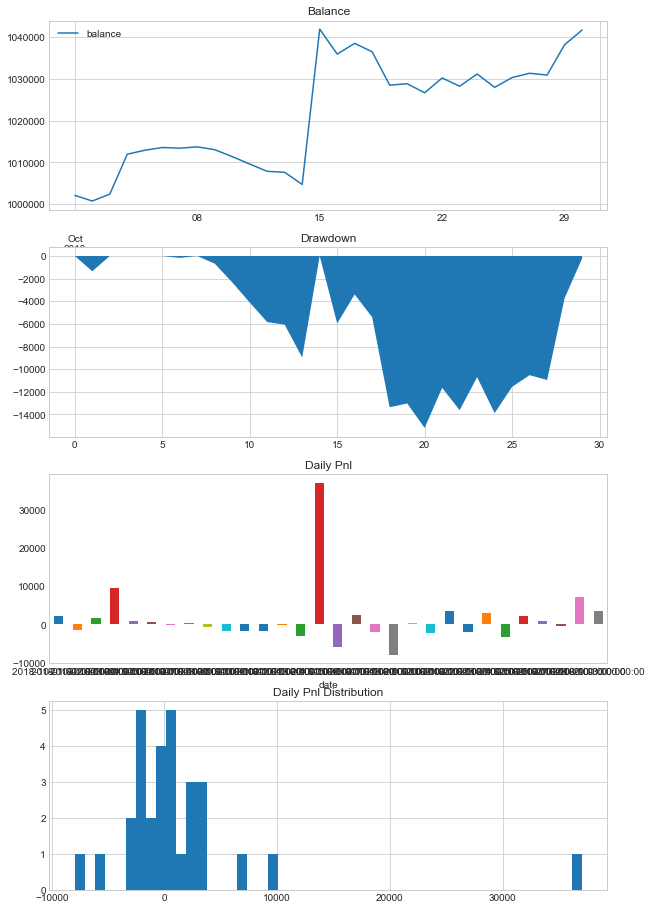

2018-12-02 00:47:42.393918	计算回测结果
2018-12-02 00:47:42.418897	交割单已生成
2018-12-02 00:47:42.418897	------------------------------
2018-12-02 00:47:42.418897	第一笔交易：	2018-10-01 12:45:00
2018-12-02 00:47:42.418897	最后一笔交易：	2018-10-30 15:58:00
2018-12-02 00:47:42.419898	总交易次数：	139
2018-12-02 00:47:42.419898	总盈亏：	29,444.92
2018-12-02 00:47:42.419898	最大回撤: 	-25,813.75
2018-12-02 00:47:42.419898	平均每笔盈利：	211.83
2018-12-02 00:47:42.419898	平均每笔滑点：	0.0
2018-12-02 00:47:42.419898	平均每笔佣金：	211.3
2018-12-02 00:47:42.419898	胜率		46.76%
2018-12-02 00:47:42.419898	盈利交易平均值	2,141.2
2018-12-02 00:47:42.419898	亏损交易平均值	-1,482.88
2018-12-02 00:47:42.419898	盈亏比：	1.44
2018-12-02 00:47:43.306941	策略回测统计图已保存


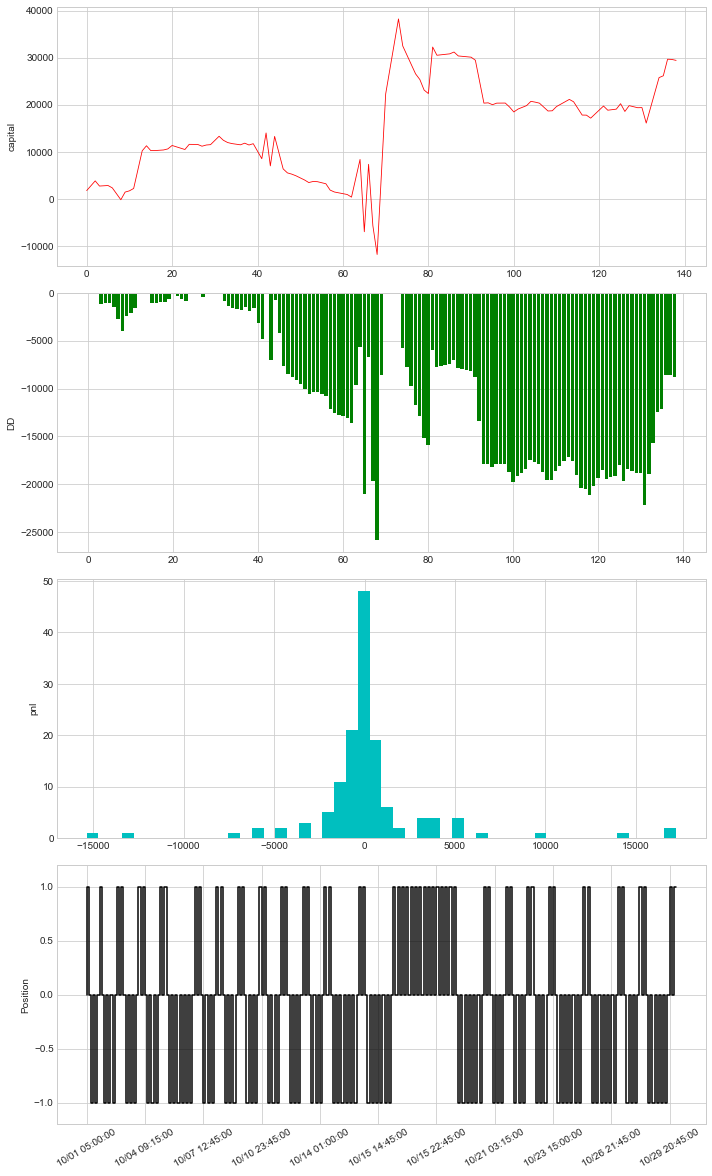

2018-12-02 00:47:44.016657	计算按日统计结果


In [53]:
from __future__ import division
from vnpy.trader.app.ctaStrategy import BacktestingEngine
from vnpy.trader.app.ctaStrategy.ctaBase import *
def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, size, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)
    engine.setDatabase(MINUTE_DB_NAME)
    engine.setStartDate(startDate, initHours=200)
    engine.setEndDate(endDate)
    engine.setSize(size)
    engine.setSlippage(slippage)
    engine.setRate(rate)
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(1000000)
    engine.setLog(True,"D:\\log\\")        # 设置是否输出日志和交割单, 默认值是不输出False
    engine.setCachePath("D:\\vnpy_data\\") # 设置本地数据缓存的路径，默认存在用户文件夹内
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    perfromance = engine.calculateDailyResult()
    perfromanceDf , result = engine.calculateDailyStatistics(perfromance)
    tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
    tradeDf = tradeReport.set_index('dt')
    return perfromanceDf, tradeDf

if __name__ == '__main__':
    # 同时传入信号与执行的数据
    performanceReport, tradeReport = \
        runBacktesting(multi_signal_Strategy, {'symbolList': ['BTCUSDT:binance',
#                                                             'EOSUSDT:binance',
                                                            #'ETHUSDT:binance',
#                                                           'eos_quarter:OKEX'
                                                            # 'tEOSUSD:bitfinex'
                                                            ]},
                       '20181001 00:00', '20181030 16:00', 10, 0, 5/10000)
    # tradeReport.to_excel('BBandMa5MinStrategyReport.xlsx')

## 绩效报告

In [3]:
tradeReport

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,price_avg,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
dt,,,,,,,,,,,,,,,,,,,
2018-10-01 12:45:00,空,,,0.0,,开仓,1,,6651.29,0.0,None,,,1,2018-10-01 12:45:00,30.0,1,BTCUSDT:binance,1
2018-10-01 16:15:00,多,,,0.0,,平仓,2,,6610.24,0.0,None,,,2,2018-10-01 16:15:00,30.0,2,BTCUSDT:binance,2
2018-10-01 16:15:00,多,,,0.0,,开仓,3,,6610.24,0.0,None,,,3,2018-10-01 16:15:00,30.0,3,BTCUSDT:binance,3
2018-10-01 16:15:00,多,,,0.0,,平仓,4,,6610.24,0.0,None,,,4,2018-10-01 16:15:00,30.0,4,BTCUSDT:binance,4
2018-10-02 07:30:00,空,,,0.0,,平仓,5,,6593.94,0.0,None,,,5,2018-10-02 07:30:00,30.0,5,BTCUSDT:binance,5
2018-10-02 07:30:00,空,,,0.0,,开仓,6,,6593.94,0.0,None,,,6,2018-10-02 07:30:00,30.0,6,BTCUSDT:binance,6
2018-10-02 07:30:00,空,,,0.0,,平仓,7,,6593.94,0.0,None,,,7,2018-10-02 07:30:00,30.0,7,BTCUSDT:binance,7
2018-10-02 07:31:00,空,,,0.0,,平仓,8,,6589.01,0.0,None,,,8,2018-10-02 07:31:00,-30.0,8,BTCUSDT:binance,8
2018-10-02 08:45:00,空,,,0.0,,开仓,9,,6595.50,0.0,None,,,9,2018-10-02 08:45:00,30.0,9,BTCUSDT:binance,9
